# Filtering

## Match Filtering

In gravitational wave data interpretation, match filtering is a technique used to detect and characterize gravitational wave signals. Match filtering takes a template waveform and slides it across the data, computing the signal-to-noise ratio (SNR) at each time. Match filtering can identify the time and phase of a signal, and can also be used to estimate the parameters of the signal.

### Using a template

The template is important in match filtering - otherwise there's nothing to match the real data with.

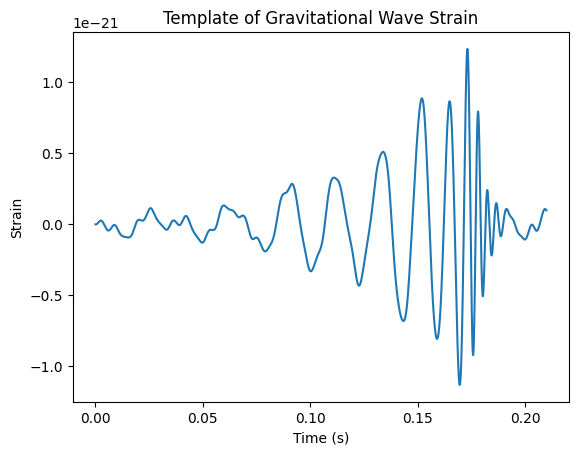

In [2]:
import matplotlib.pyplot as plt
import numpy as np

template_data = np.loadtxt('numericalRelativity.txt')

template_time = np.array(template_data[:,0])
template_time = template_time - np.min(template_time)
template_strain = np.array(template_data[:,1]) * 1e-21

plt.figure()
plt.plot(template_time, template_strain)
plt.title('Template of Gravitational Wave Strain')
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.show()

In [5]:
# Showing the template on real data
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)
h1_strain = hdata.value
h1_time = hdata.times.value
adj_h1_time = h1_time - np.min(h1_time)

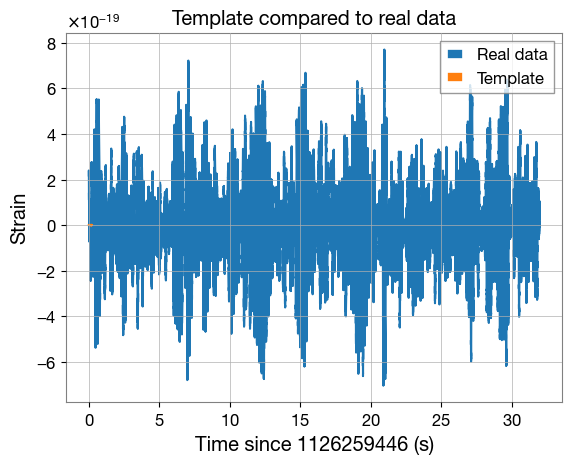

In [6]:
adj_template_strain = template_strain

plt.figure()
plt.plot(adj_h1_time, h1_strain, label='Real data')
plt.plot(template_time, adj_template_strain, label='Template')
plt.legend()
plt.title('Template compared to real data')
plt.xlabel('Time since 1126259446 (s)')
plt.ylabel('Strain')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


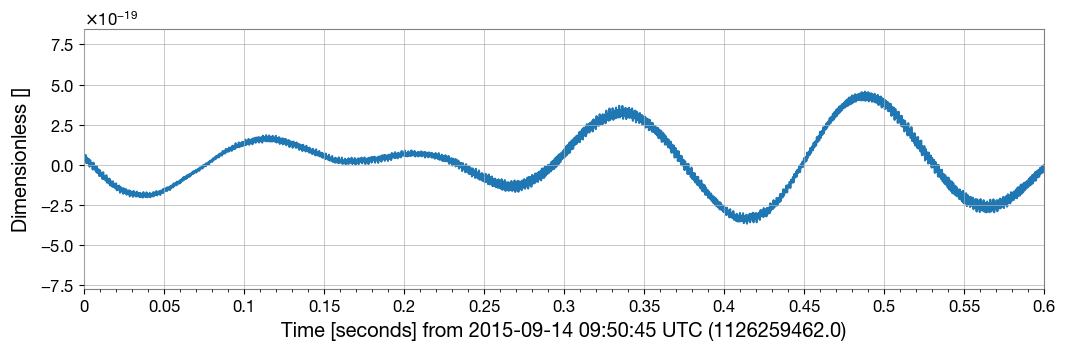

In [7]:
# Zooming in on the data
plot = hdata.plot()
ax = plot.gca()
ax.set_xlim(1126259446 + 16, 1126259446 + 16.6)
plot.show()

In [8]:
# Designing a filter for signal detection
from gwpy.signal import filter_design
bandpass = filter_design.bandpass(50, 250, hdata.sample_rate) # Bandpass from 50-250 Hz
notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 120, 180)] # Notch filters to remove 60, 120, 180 Hz lines
zpk = filter_design.concatenate_zpks(bandpass, *notches)
hfilt = hdata.filter(zpk, filtfilt=True) # Creating bp and notch filter; what is ZPK??

# Filters corrupt some data at beginning and end of data, so crop ends
hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


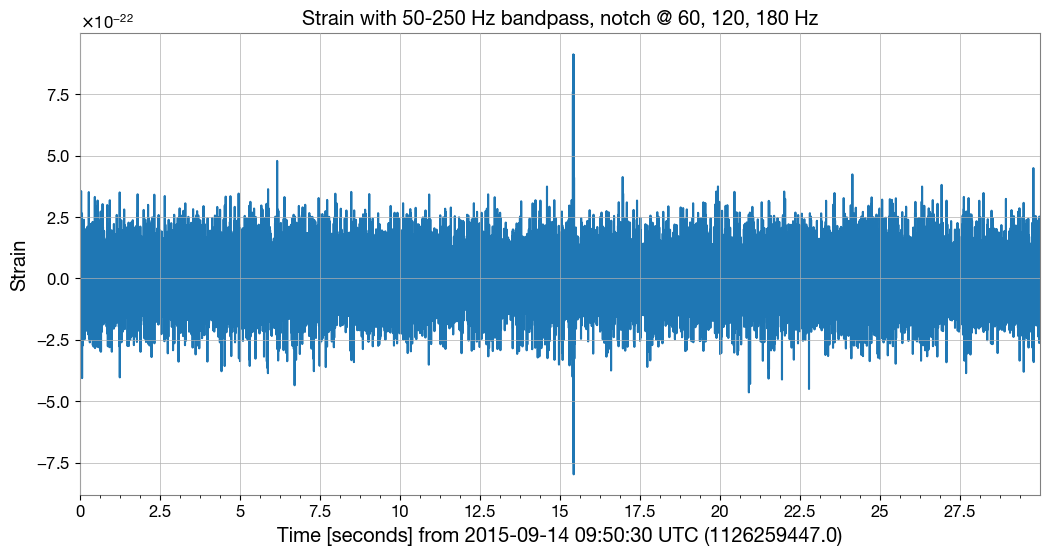

In [24]:
# Plotting
from gwpy.plot import Plot
plot = Plot(hfilt)
ax = plot.gca()
ax.set_title('Strain with 50-250 Hz bandpass, notch @ 60, 120, 180 Hz')
ax.set_ylabel('Strain')
plot.save('filtered_strain.png')
plot.show()

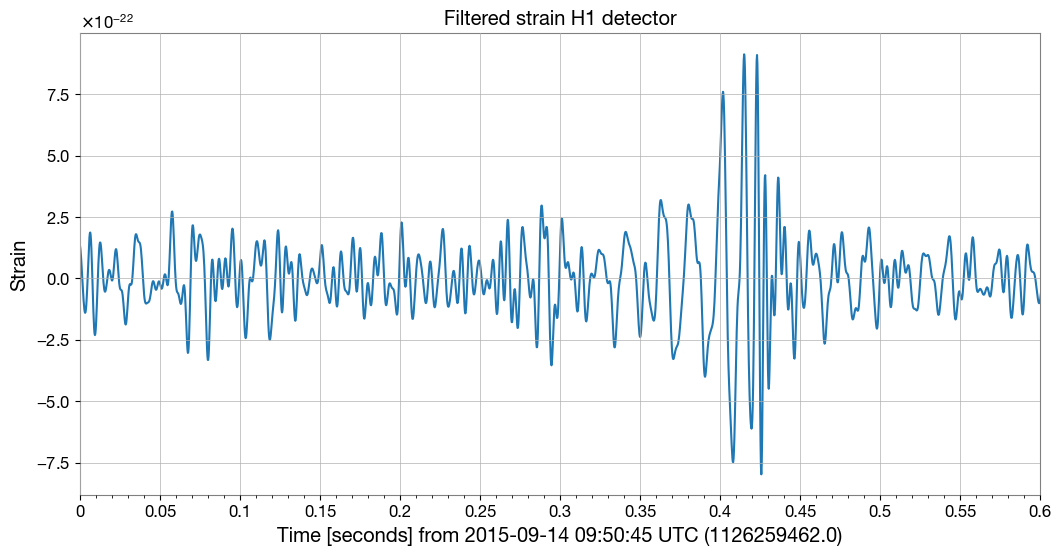

In [10]:
# Zooming in
plot = Plot(hfilt)
ax = plot.gca()
ax.set_xlim(1126259462, 1126259462.6)
ax.set_title('Filtered strain H1 detector')
ax.set_ylabel('Strain')
plot.show()

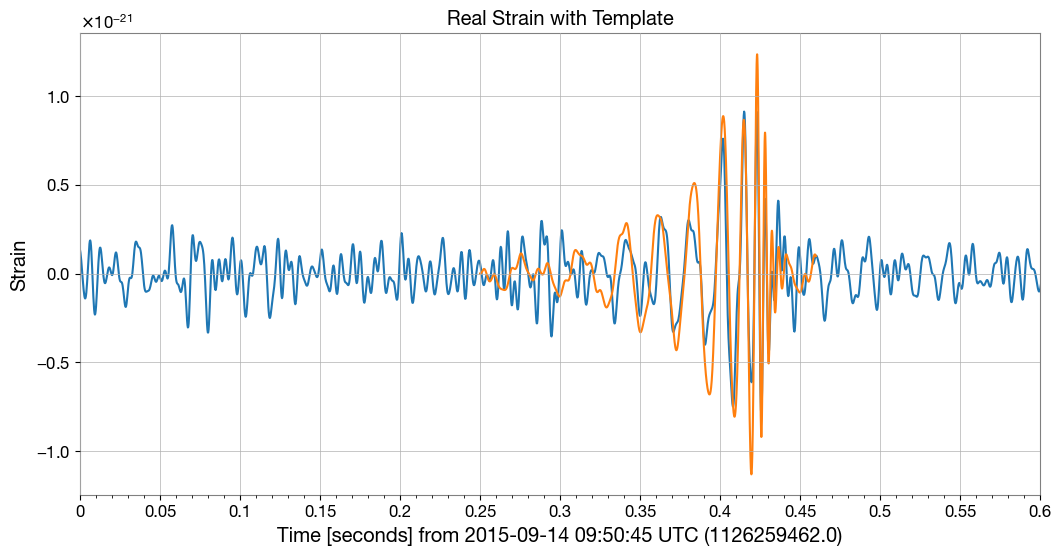

In [11]:
n = 1000
dt = template_time[n + 1] - template_time[n]
template = TimeSeries(template_strain, None, 1126259462.25, dt)
plot = Plot(hfilt, template)
ax = plot.gca()
ax.set_xlim(1126259462, 1126259462.6)
ax.set_title('Real Strain with Template')
ax.set_ylabel('Strain')
plot.show()

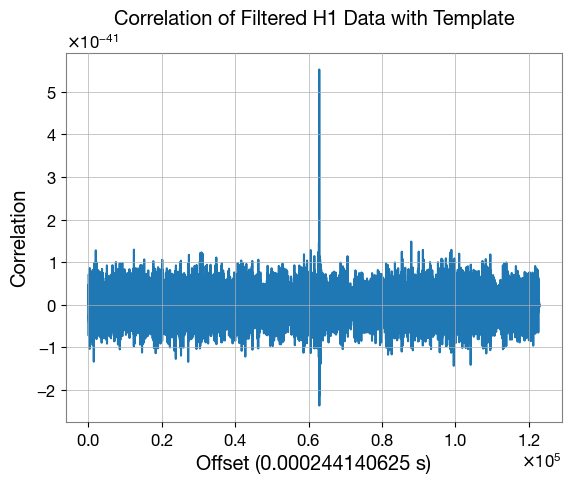

In [12]:
# Correlating template with real data
from scipy.signal import resample, correlate

num_points_template = int(round((len(template) * template.dt.value) / hfilt.dt.value))
resampled_template = resample(template, num_points_template)
correlation = correlate(hfilt.value, resampled_template, mode='same')
plt.figure()
plt.plot(correlation)
plt.title('Correlation of Filtered H1 Data with Template')
plt.ylabel('Correlation')
plt.xlabel(f'Offset ({hfilt.dt})')
plt.show()


Maximum correlation of 5.525698458863586e-41 at 1126259462.25 s)


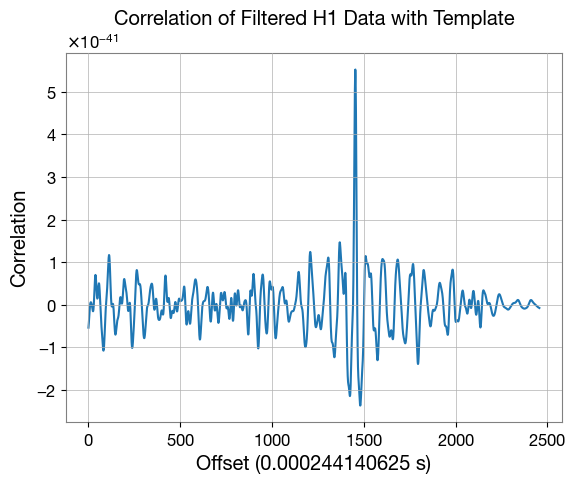

In [21]:
# Filtering on a smaller range of data
correlation = correlate(hfilt.crop(1126259462, 1126259462.6).value, resampled_template, mode='same')
time_of_max_correlation = np.argmax(correlation) * hfilt.dt.value + 1126259462 - hfilt.dt.value * len(resampled_template) / 2
print(f'Maximum correlation of {np.max(correlation)} at {time_of_max_correlation} s)')
plt.figure()
plt.plot(correlation)
plt.title('Correlation of Filtered H1 Data with Template')
plt.ylabel('Correlation')
plt.xlabel(f'Offset ({hfilt.dt})')
plt.savefig('correlation.png')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gwpy/plot/plot.py:287: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


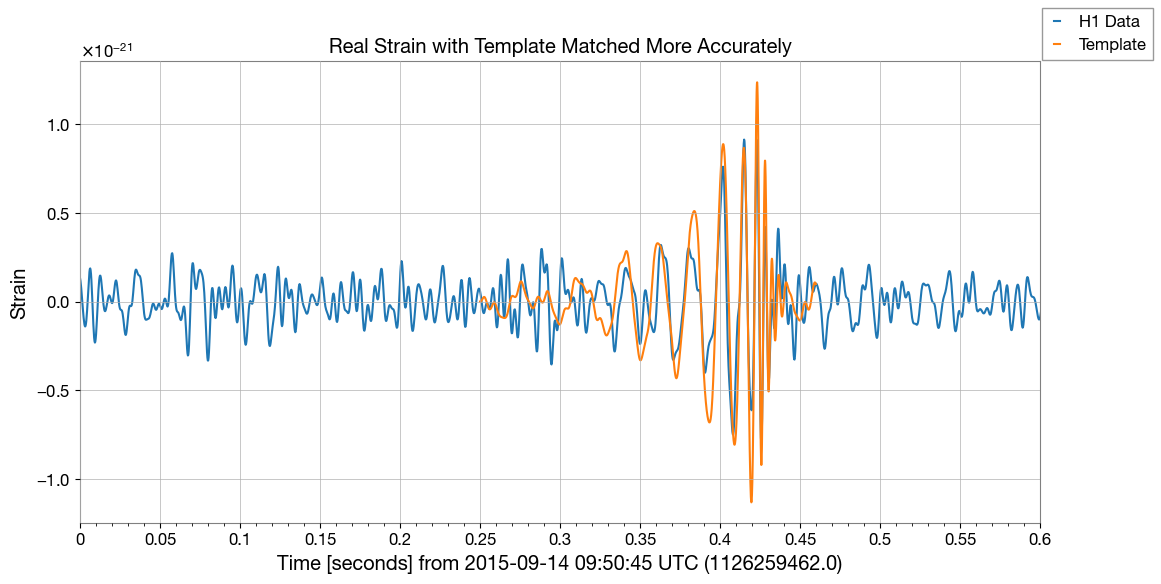

In [22]:
# Plotting with a more exact match
template = TimeSeries(template_strain, None, time_of_max_correlation, dt)
plot = Plot(hfilt, template)
ax = plot.gca()
ax.set_xlim(1126259462, 1126259462.6)
ax.set_title('Real Strain with Template Matched More Accurately')
ax.set_ylabel('Strain')
plot.legend(['H1 Data', 'Template'])
plot.savefig('matched_filter.png')
plot.show()

In [23]:
# Write to CSV
hfilt.write('filtered_strain.csv', format='csv')
template.write('template.csv', format='csv')
